# Sample selection
The random sample dataset is composed of marginal ice zone (MIZ) locations and dates from 9 Arctic regions. The dates are selected based on the climatology of sea ice cover for each region. Each scene is 100 km by 100 km and centered on a location where the NSIDC climate data record v5 (CDR) of sea ice concentration shows between 15 and 85%. The CDR is used to find candidate samples, as the dataset can be accessed quickly. Since the resolution is 25 km, each candidate scene only contains a few CDR pixels. We refine the candidate samples by computing the sea ice cover from the MASIE 4 km data.
Only scenes with at least 25% sea ice fraction (area with SIC > 15%) are considered. 

MODIS images are available since 2000 (terra) and 2002 (aqua), however the MASIE sea ice extent imagery is only available since 2006. So we draw our sample from 2006 to 2023 (the last full year of NSIDC data at time of writing).

Sample selection needs to balance two competing issues:
(a) the size of the image needs to be large enough that there is a useful range of floe sizes that can be resolved
(b) the number of scenes should be large enough that we can consider it a representative random sample
Because the time needed to manually annotate an image is proportional to the image area, the number of images that can be analyzed is strongly limited by the image size. 

First, nine regions spanning the circumpolar Arctic seasonal ice zones were selected (Figure 1, Table 1). The regions were selected to have equal area. The file `setup_locations.py` makes a CSV file `data/metadata/region_definitions.csv`.

We perform stratified random sampling to select a set of images for the validation dataset.
We use the NSIDC Sea Ice Concentration Climate Data Record (SIC CDR) to identify periods of time that each region contains some overlap with the sea ice region. We acknowledge that uncertainty in SIC CDR is high during the summer. Since the purpose of using the SIC CDR in the random sampling is to find a wide range of sea ice conditions, rather than to make inferences about sea ice physics in these regions, we consider the SIC CDR suitable for this purpose.

Within each region, we follow the following procedure
* Randomly choose a start year and a date between March and region-specific end date (max September 30)
* Select a center point (x, y) from the CDR grid that is at least 50 km from the region border
* Calculate sea ice fraction for the 100 km box centered at the point
* If the sea ice fraction is at least 0.25, add date and center point to list of cases
* Check the number of cases.
   * If the minimum number of cases per month is met, move to the next region.
    
We start by generating a set of samples larger than is needed for the validation dataset, saving 10 candidate cases per month, per region. We then stratify the sample to get minimum 3 samples per month, with randomly chosen additional samples chosen to bring the number to 21 dates per region for locations where sea ice is present less than 7 months of the summer. Thus, there are more samples for March in the Sea of Okhostk than in the Beaufort Sea.

## History of dataset development
Developing the random sample dataset began in Spring 2024. Initial samples were drawn using the same functions as below, but for equal-area regions. Because the region boundaries overlapped, some points had ambiguous region membership. We also found 

We include some samples drawn from the same sampling procedure with slightly different region definitions. We refined the region definitions to avoid overlaps and to align better with the IHO marginal sea definitions, and we extended the time range an additional year. To ensure that the sampling was still random according to the procedure described above, we drew a large set of new sample locations, then computed the relative fraction within the old domain and with the modified domain. Using the relative fractions from the overlapping and non-overlapping regions, we drew samples from the new regions until the proportion was correct.

The code below takes the original sample, used in the Simon Hatcher's batchelor's thesis (Hatcher 2024), then resamples the region to create a random sample representative of the new region. Consider a region $X$ and a new, overlapping region $Y$. We posses a sample of $n_X$ points from region $X$ and wish to form a sample of points from $Y$. Drawing a random sample of $m$ points from $Y$, we separate them into $m_{X}$ points from $Y \cap X$ (i.e., the points in $Y$ that are also in $X$), and $m_{Y \setminus X}$ points that are in region of $Y$ excluding $X$. Thus, $m_X + m_{Y \setminus X} = m_{Y}$. To extend our original sample, we randomly select up to $m_X$ points from the $n_X$ original points. If $n_X < m_X$, we replace $n_X$ points from the $m_X$ new points with points from the old sample, and keep $m_X - n_X$ points from the new sample. If $n_X >= m_X$, we draw $m_X$ of the originally sampled points at random to keep in the new sample.

### Need for additional samples
During the manual analysis of the downloaded images, there are a few reasons that a case can be rejected and replaced.
1. Image corrupted. MODIS coverage is generally excellent, but it can happen that an image is missing due to data problems.
2. Error in the NSIDC sea ice concentration. It is known that there are positive biases in SIC along coastlines, where there is mismatch between the details of the true coastline and the coarse mask used by the algorithm. For these regions, the MASIE ice extent is considered more reliable. However, each MASIE image is 37.8 MB making it prohibitive to access and calculate SIC at the initial sampling stage. We download and compute MASIE ice fraction for all the selected samples, and if MASIE shows 0 ice concentration and the visual analysis confirms it we reject the sample, drawing a new sample for the same location and same month.
3. Insufficient ocean area. The algorithms are run on regions outside a dilated landmask. In some cases, the landmask dilation results in 0 (or very few) analyzed pixels, so there is no region to compare.



# Defining the regions
We define our sampling regions based on the International Hydrographic Organization (IHO) Limits of Oceans and Seas. As the satellite data is provided in polar stereographic coordinates, we select rectangular regions with bounds selected from the landmarks dividing the IHO defined seas. Thus, the boundaries are not intended to be exactly identical to the IHO seas. Boundaries are defined in the script `setup_locations.py`. An image is below. Examples of boundaries:

1. Greenland Sea: Northern bound is the line from northernmost point of Spitzbergen to the Northernmost part of Greenland. Eastern bound is the west coast of West Spitzbergen and Jan Mayen. Southern bound is Iceland.

Barents Sea: West bound is line joining West Spitzbergen to Bear Island to North Cape of norway. Northwest bound is west spitzbergen to cape leigh smith. Norht bound across Bolshoy Ostrov, Alexandra Land, and northern coast of Franz-Josef Land. West coasts of Novaya Zemlya.

Kara Sea on the north is Severnaya Zemlya, on the east is Komsomolets Island, Bolshevik Island.

We use the north extent of the greenland sea as the lower bound for the barents-kara region, and the center of Severnaya Zemlya as the left extent. Upper bound is the Tamyr Peninsula. Right bound is the entrance to the White Sea.
Laptev Sea: left extent the New Siberian Islands, right extent 

East siberian sea: left extent Wrangel Island, right extent the New Siberian Islands. North extent: we go all the way to Point Barrow in polar stereographic coordinates. Upper extent the russian mainland.

Bering-Chukchi Seas: right extent is wrangel island, lower extent is point barrow. Extended domain 1500 km to the left and upwards. 

## Load the regions

In [4]:
import pandas as pd
import pyproj
import xarray as xr
import proplot as pplt
import cartopy.crs as ccrs
import os
import numpy as np
import warnings
warnings.simplefilter('ignore')

regions = pd.read_csv('../data/metadata/region_definitions.csv', index_col=0)
old_regions = pd.read_csv('../data/metadata/init_region_definitions.csv', index_col=0)
old_regions.rename({'top_y': 'upper_y'}, axis=1, inplace=True)

<a list of 1 Line2D objects>

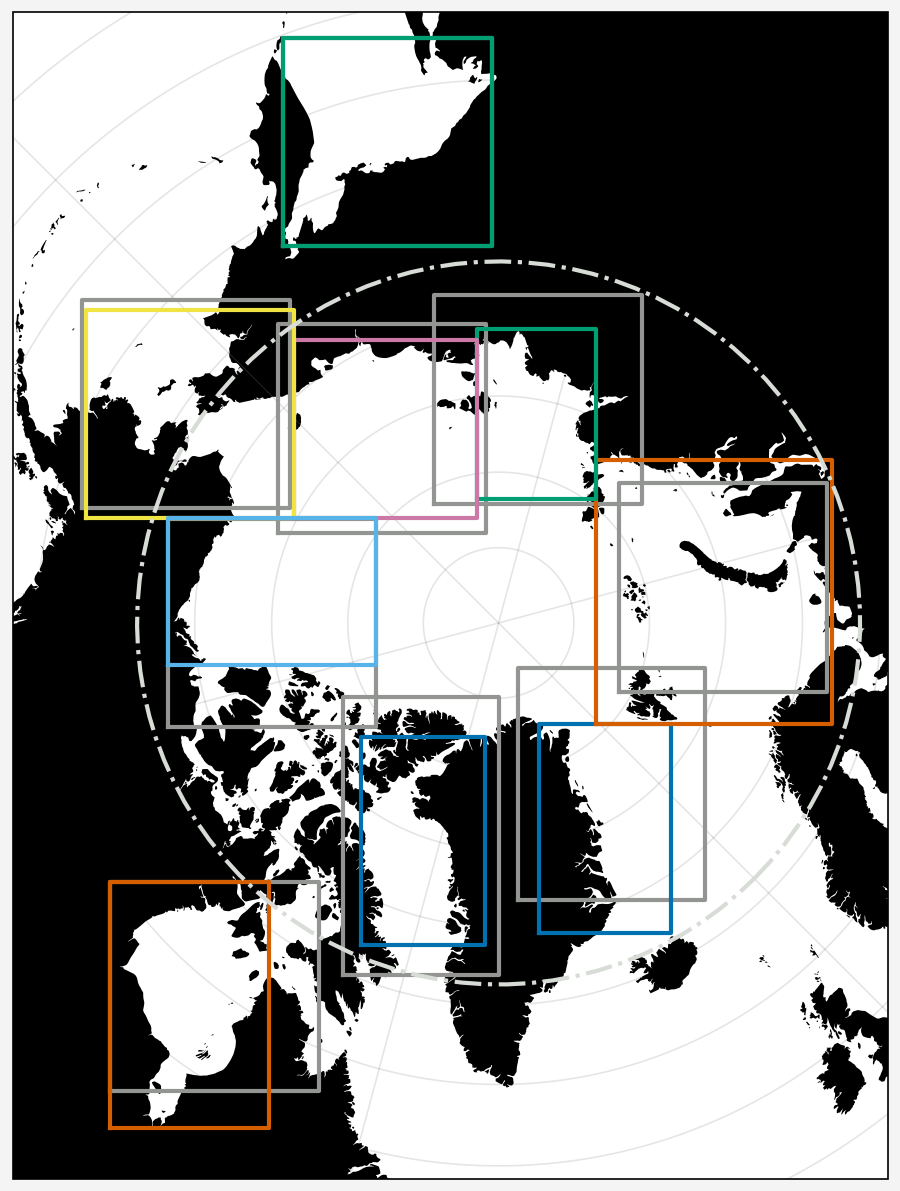

In [5]:
# Plot bounds of former and new regions
pplt.rc['reso'] = 'med'
pplt.rc['cartopy.circular'] = False

crs = ccrs.CRS('epsg:3413')
fig, ax = pplt.subplots(width=4.5, proj='npstere', proj_kw={'lon_0': -45})
ax.format(land=True, color='k', boundinglat=52, landzorder=0, latmax=90)
ax.set_extent([-3.5e6, 2.8e6, -4e6, 4.4e6], crs=crs)

for region in old_regions.index:
    xbox = np.array([old_regions.loc[region, coord] for coord in ['left_x', 'left_x', 'right_x', 'right_x', 'left_x']])
    ybox = np.array([old_regions.loc[region, coord] for coord in ['lower_y', 'upper_y', 'upper_y', 'lower_y', 'lower_y']])
    ax.plot(xbox, ybox, transform=crs, color='gray')

for region in regions.index:
    xbox = np.array([regions.loc[region, coord] for coord in ['left_x', 'left_x', 'right_x', 'right_x', 'left_x']])
    ybox = np.array([regions.loc[region, coord] for coord in ['lower_y', 'upper_y', 'upper_y', 'lower_y', 'lower_y']])
    ax.plot(xbox, ybox, transform=crs)

ax.plot(np.linspace(0, 360, 100), np.ones(100)*66.3, ls='-.', color='light gray')

In [57]:
ds_april_mean = ds_april[['cdr_seaice_conc']].where(ds_april[['cdr_seaice_conc']] <= 1).mean(dim='tdim')
ds_sept_mean = ds_sept[['cdr_seaice_conc']].where(ds_sept[['cdr_seaice_conc']] <= 1).mean(dim='tdim')

In [39]:
df = pd.read_csv('../data/metadata/daily_sea_ice_fraction.csv', index_col=0, parse_dates=True)
df['doy'] = df.index.dayofyear

p90 = df.groupby('doy').quantile(0.9)
for region in p90:
    print(region, p90[region][p90[region] > 0.05].index.max())

greenland_sea 274
barents_kara_seas 274
laptev_sea 274
east_siberian_sea 274
bering_chukchi_seas 236
beaufort_sea 274
baffin_bay 274
hudson_bay 218
sea_of_okhostk 178


shading: region with 15-85% SIC in April and September, 2006-2024.

## Get start and end dates from the SIF data

In [8]:
import os
import pyproj
import numpy as np
import pandas as pd
import xarray as xr

In [9]:
sif_data = pd.read_csv('../data/metadata/daily_sea_ice_fraction.csv', index_col=0, parse_dates=True)
threshold = 0.05
end_doy = sif_data.groupby(sif_data.index.dayofyear).quantile(0.90).apply(lambda x: x[x >= threshold].index.max())
start_doy = pd.Series(pd.to_datetime('2003-03-01').dayofyear, index=end_doy.index)

In [10]:
# regions.merge(end_doy, left_index=True, right_index=True)
regions.loc[end_doy.index, 'end_doy'] = end_doy.values
regions.loc[start_doy.index, 'start_doy'] = start_doy.values
regions.loc[start_doy.index, 'start_mmdd'] = (pd.to_timedelta(regions['start_doy'] - 1, unit='D') + pd.to_datetime('2001-01-01 00:00')).dt.strftime('%b %d')
regions.loc[end_doy.index, 'end_mmdd'] = (pd.to_timedelta(regions['end_doy'] - 2, unit='D') + pd.to_datetime('2001-01-01 00:00')).dt.strftime('%b %d')
regions.sort_values('center_lon').loc[:, ['start_doy', 'end_doy', 'start_mmdd', 'end_mmdd']].to_csv('../data/metadata/sample_start_end_times.csv')

In [11]:
old_regions.rename({'chukchi_east_siberian_seas': 'east_siberian_sea',
                    'bering_strait': 'bering_chukchi_seas'}, axis=0, inplace=True)

In [12]:
regions.loc[:, ['center_lat', 'center_lon', 'start_mmdd', 'end_mmdd']]

,center_lat,center_lon,start_mmdd,end_mmdd
greenland_sea,74.6976,-17.6011,Mar 01,Sep 30
barents_kara_seas,75.6170,53.2228,Mar 01,Sep 30
laptev_sea,75.9228,124.6890,Mar 01,Sep 30
east_siberian_sea,75.1712,165.1917,Mar 01,Sep 30
bering_chukchi_seas,65.5956,-169.0758,Mar 01,Aug 23
beaufort_sea,74.8600,-142.8400,Mar 01,Sep 30
baffin_bay,74.7679,-64.0848,Mar 01,Sep 30
hudson_bay,58.1426,-83.9645,Mar 01,Aug 05
sea_of_okhostk,58.0000,148.0000,Mar 01,Jun 26


## Functions for generating stratified random sample
These functions carry out the random sampling and sea ice fraction checks. They are used iteratively to build the random sample.

In [1]:
sic_dataloc = '/Users/dwatkin2/Documents/research/data/nsidc_daily_cdr_v4/'
def compute_sic(left_x, right_x, lower_y, upper_y, sic_data):
    """Computes the sea ice extent as a fraction of total area within the region bounded
    by <left_x>, <right_x>, <bottom_y>, and <top_y> using the netcdf file <sic_data>. Assumes
    that sic_data is the NSIDC SIC CDR."""

    x_idx = (sic_data.xgrid >= left_x) & (sic_data.xgrid <= right_x)
    y_idx = (sic_data.ygrid >= lower_y) & (sic_data.ygrid <= upper_y)
    
    with_ice = ((sic_data.sel(x=x_idx, y=y_idx)['cdr_seaice_conc'] > 0.15) & \
                (sic_data.sel(x=x_idx, y=y_idx)['cdr_seaice_conc'] <= 1))
    coast_mask = (sic_data.sel(x=x_idx, y=y_idx)['cdr_seaice_conc'] > 1).sum() 
    total_area_pixels = np.prod(with_ice.shape)
    sic_area_pixels = with_ice.sum().data
    sic_mean = (sic_data.sel(x=x_idx, y=y_idx).where(with_ice))['cdr_seaice_conc'].mean().data
    return {'sea_ice_fraction': np.round(sic_area_pixels/(total_area_pixels - coast_mask.data), 3),
            'mean_sea_ice_concentration': np.round(sic_mean, 3)}

def find_candidates(n_samples, region_info, dx, sic_path,
                    sif_threshold=0.25, margin=50, start_year=2003, end_year=2022,
                    min_samples_per_month=10):
    """Generates a list of candidate locations for the validation dataset. Initial samples were selected using the
    same steps as shown here. This function places the steps in one place for convenience, and implements a correction
    to the SIC calculation used in the initial version.
    
    n: sets the number of candidates to generate.
    region_info: a row from the region_definitions table. Must include start_doy and end_doy.
    dx is the dimension in km of the sample scene.
    sic_path: path to folder with the NSIDC CDR data.
    sif_threshold: between 0 and 1. The ice fraction needed to retain a sample.
    margin: distance in km that the center needs to be from the edge of the region boundary.
    """
    
    dx_meters = dx*1e3
    margin_meters = margin * 1e3
    region = region_info.name
    start_doy = region_info.start_doy
    end_doy = region_info.end_doy
    left_x = region_info.left_x
    right_x = region_info.right_x
    lower_y = region_info.lower_y
    upper_y = region_info.upper_y

    # calculations are done in polar stereographic
    # use pyproj to convert back to lon/lat for final table
    crs0 = pyproj.CRS('WGS84')
    crs1 = pyproj.CRS('epsg:3413')
    transformer_ll = pyproj.Transformer.from_crs(crs1, crs_to=crs0, always_xy=True)
    
    # we keep track of the number of samples generated per month
    # the range is set up this way so that we don't get extra months in 
    # leap years. For other uses the start and end doy could be adjusted differently.
    start_month = (pd.to_datetime('2000-01-01') + pd.to_timedelta(start_doy, unit='d')).month
    end_month = (pd.to_datetime('2000-01-01') + pd.to_timedelta(end_doy - 1, unit='d')).month
    samples_by_month = pd.Series(0, index=np.arange(start_month, end_month+1))
    candidates = []
    
    def in_box(x, y, margin_meters):
        """Convenience function that checks whether point x, y is in region.
        Returns True if x, y in the box."""
        if left_x <= x - margin_meters:
            if right_x >= x + margin_meters:
                if lower_y <= y - margin_meters:
                    if upper_y >= y + margin_meters:
                        return True
        return False
    
    while np.any(samples_by_month < min_samples_per_month):
        # Randomly select date from months with not enough samples
        year = np.random.choice(np.arange(start_year, end_year+1))
        remaining_months = list(samples_by_month[samples_by_month < min_samples_per_month].index)
        month = np.random.choice(remaining_months)
        days_in_month = pd.to_datetime(str(year) + '-' + str(month) + '-01').daysinmonth
        day = np.random.choice(np.arange(1, days_in_month+1))
        date = str(year) + str(month).zfill(2) + str(day).zfill(2)
        
        # Load SIC data for the date. If any MIZ regions, randomly select center point
        # with sea ice concentration between 15 and 85 percent, otherwise pass    
        min_ice = 0.15
        max_ice = 0.85
        
        files = os.listdir(sic_path + str(year))
        if 'f17' in files[0]:
            f = 'seaice_conc_daily_nh_' + date + '_f17_v04r00.nc'
        else:
            f = 'seaice_conc_daily_nh_' + date + '_f13_v04r00.nc'
            
        with xr.open_dataset(sic_dataloc + str(year) + '/' + f) as sic_data:
            # generate center point
            X, Y = np.meshgrid(sic_data.xgrid, sic_data.ygrid)
            miz = (sic_data['cdr_seaice_conc'] >= min_ice) & (sic_data['cdr_seaice_conc'] <= max_ice)
            miz = np.ravel(miz.squeeze())
            xoptions = np.ravel(X)[miz]
            yoptions = np.ravel(Y)[miz]
            inside = np.array([in_box(x, y, margin_meters) for x, y in zip(xoptions, yoptions)])
    
            if np.any(inside):
                ii = np.random.choice(np.arange(len(xoptions))[inside])
                
                # get x, y coordinates
                x0 = xoptions[ii]
                y0 = yoptions[ii]

                # define scene centered at x0, y0
                left_x0 = x0 - dx_meters/2
                right_x0 = x0 + dx_meters/2
                lower_y0 = y0 - dx_meters/2
                upper_y0 = y0 + dx_meters/2
                
                sic_results = compute_sic(left_x0, right_x0, lower_y0, upper_y0, sic_data)
                # check SIF threshold
                if sic_results['sea_ice_fraction'] >= sif_threshold:
                    lon0, lat0 = transformer_ll.transform(x0, y0)
                    candidates.append([region, pd.to_datetime(date).strftime('%Y-%m-%d'),
                                       lon0, lat0, x0, y0, sic_results['sea_ice_fraction'],
                                       sic_results['mean_sea_ice_concentration']])
                    samples_by_month[month] += 1

    candidates = pd.DataFrame(candidates,
            columns=['region', 'start_date', 'center_lon', 'center_lat',
                     'center_x', 'center_y', 'sea_ice_fraction', 'mean_sea_ice_concentration'])

    candidates['month'] = pd.to_datetime(candidates['start_date'].values).month
    return candidates

The original sample selection is based on a random sample from a slightly different, overlapping region from an earlier iteration of the planned study. If data was equally likely to come from anywhere in the area, then we would just need to adjust sample size to proportionately come from the different area. However, the difference in *MIZ* area is the important thing, and that varies by day and year. So we do a numerical experiment to see the fraction of data by month that should come from the additional data regions.

This code takes the old region bounds, and computes the fraction per month expected to come from old vs. new regions.

In [18]:
old_regions['start_doy'] = regions['start_doy']
old_regions['end_doy'] = regions['end_doy']
old_regions

,center_lat,center_lon,center_x,center_y,left_x,right_x,lower_y,upper_y,start_doy,end_doy
region,,,,,,,,,,
baffin_bay,75,-65,-5.588197e+05,-1.535345e+06,-1.121320e+06,3.680300e+03,-2.535345e+06,-5.353445e+05,60.0,274.0
barents_kara_seas,75,54,1.613764e+06,2.555951e+05,8.637637e+05,2.363764e+06,-4.944049e+05,1.005595e+06,60.0,274.0
beaufort_sea,75,-135,-1.633879e+06,-1.000463e-10,-2.383879e+06,-8.838795e+05,-7.500000e+05,7.500000e+05,60.0,274.0
bering_chukchi_seas,65,-170,-2.252871e+06,1.577477e+06,-3.002871e+06,-1.502871e+06,8.274773e+05,2.327477e+06,60.0,236.0
east_siberian_sea,75,166,-8.415102e+05,1.400508e+06,-1.591510e+06,-9.151015e+04,6.505081e+05,2.150508e+06,60.0,274.0
greenland_sea,77,-10,8.110851e+05,-1.158350e+06,1.360851e+05,1.486085e+06,-1.991683e+06,-3.250162e+05,60.0,274.0
hudson_bay,60,-83,-2.045942e+06,-2.618686e+06,-2.795942e+06,-1.295942e+06,-3.368686e+06,-1.868686e+06,60.0,218.0
laptev_sea,75,125,2.837202e+05,1.609057e+06,-4.662798e+05,1.033720e+06,8.590572e+05,2.359057e+06,60.0,274.0
sea_of_okhostk,58,148,-7.998909e+05,3.464708e+06,-1.549891e+06,-4.989095e+04,2.714708e+06,4.214708e+06,60.0,178.0


In [68]:
%%time
# bering-chukchi
# beaufort (slightly - no explicit reason for specific north bound tho)
# hudson_bay
# barents-kara seas
# greenland_sea
results = {}
for region in ['bering_chukchi_seas', 'beaufort_sea', 'hudson_bay', 'barents_kara_seas', 'greenland_sea']:
    
    row = regions.loc[region]
    test = find_candidates(n_samples=2000,
                    region_info=row,
                    dx=100,
                    sic_path=sic_dataloc,
                    sif_threshold=0.25,
                    margin=50, start_year=2003, end_year=2022,
                    min_samples_per_month=200) # Margin keeps the edges of boxes inside the outer bounds.
    
    test['in_new_minus_old'] = False
    test.loc[[name for name, row in test.iterrows() if in_new_minus_old(row, region, regions, old_regions)], 'in_new_minus_old'] = True
    results[region] = test
    print(region)

bering_chukchi_seas
beaufort_sea
hudson_bay
barents_kara_seas
greenland_sea
CPU times: user 3min 37s, sys: 8.32 s, total: 3min 46s
Wall time: 14min 14s


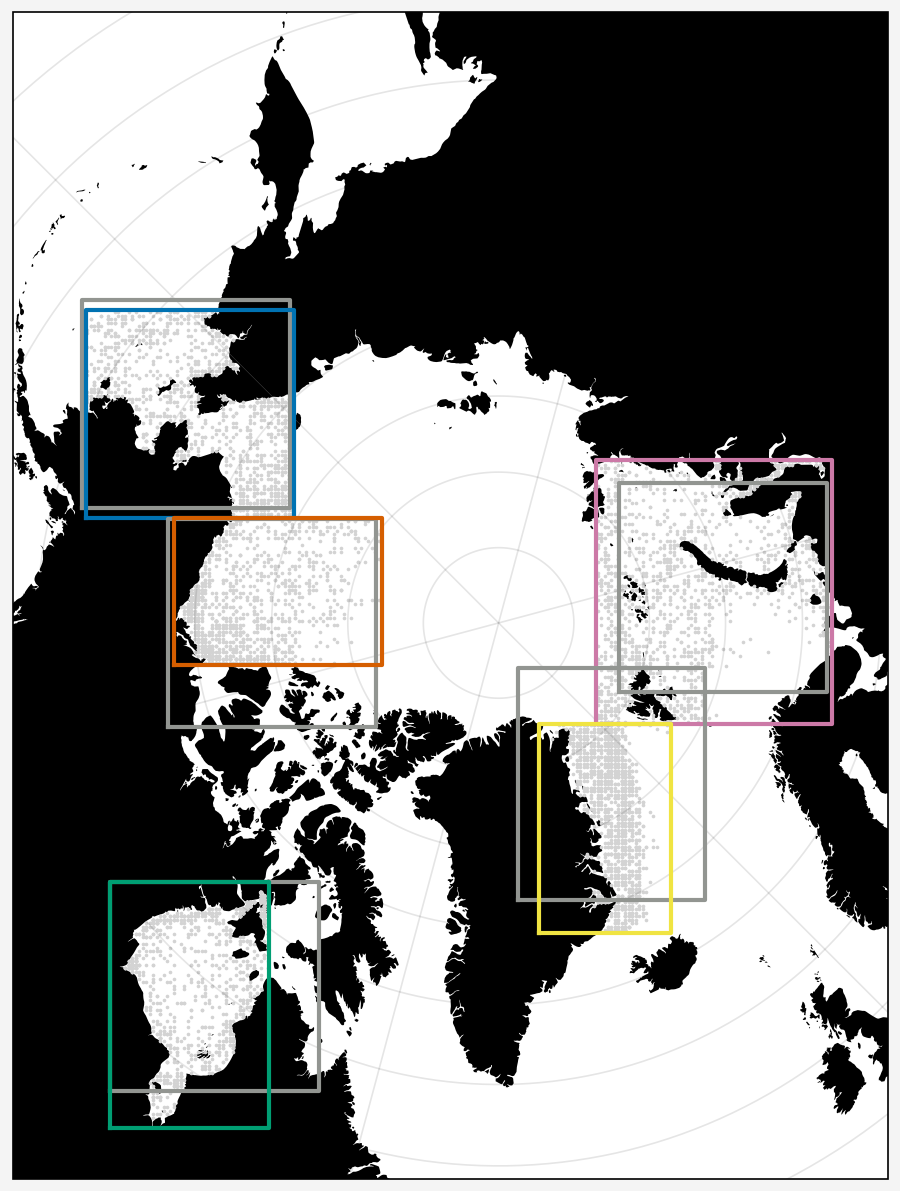

In [78]:
pplt.rc['reso'] = 'med'
pplt.rc['cartopy.circular'] = False

crs = ccrs.CRS('epsg:3413')
fig, ax = pplt.subplots(width=4.5, proj='npstere', proj_kw={'lon_0': -45})
ax.format(land=True, color='k', boundinglat=52, landzorder=0, latmax=90)
ax.set_extent([-3.5e6, 2.8e6, -4e6, 4.4e6], crs=crs)

for region in results:
    xbox = np.array([old_regions.loc[region, coord] for coord in ['left_x', 'left_x', 'right_x', 'right_x', 'left_x']])
    ybox = np.array([old_regions.loc[region, coord] for coord in ['lower_y', 'upper_y', 'upper_y', 'lower_y', 'lower_y']])
    ax.plot(xbox, ybox, transform=crs, color='gray')
    
    
    xbox = np.array([regions.loc[region, coord] for coord in ['left_x', 'left_x', 'right_x', 'right_x', 'left_x']])
    ybox = np.array([regions.loc[region, coord] for coord in ['lower_y', 'upper_y', 'upper_y', 'lower_y', 'lower_y']])
    ax.plot(xbox, ybox, transform=crs)
    
    ax.scatter(results[region]['center_lon'], results[region]['center_lat'], color='lightgray', marker='.', ms=2)
    # ax.scatter(test['center_lon'], test['center_lat'], color='tab:blue', marker='.')

In [2]:
def in_box(x, y, left_x, right_x, lower_y, upper_y):
    """Convenience function that checks whether point x, y is in region.
    Returns True if x, y in the box."""
    margin = 50e3 # margin in meters
    if left_x <= x - margin:
        if right_x >= x + margin:
            if lower_y <= y - margin:
                if upper_y >= y + margin:
                    return True
    return False
    
def in_new_minus_old(point, region, new_regions, old_regions):
    """Checks whether point is in the set defined by the new region
    (regions.loc[region,:]) excluding the area of the old region
    (old_regions.loc[region,:])"""
        
    old_xmin = old_regions.loc[region, 'left_x']
    old_xmax = old_regions.loc[region, 'right_x']
    old_ymin = old_regions.loc[region, 'lower_y']
    old_ymax = old_regions.loc[region, 'upper_y']

    new_xmin = new_regions.loc[region, 'left_x']
    new_xmax = new_regions.loc[region, 'right_x']
    new_ymin = new_regions.loc[region, 'lower_y']
    new_ymax = new_regions.loc[region, 'upper_y']
    
    
    in_old = in_box(point.center_x, point.center_y, old_xmin, old_xmax, old_ymin, old_ymax)
    in_new = in_box(point.center_x, point.center_y, new_xmin, new_xmax, new_ymin, new_ymax)
    return in_new & ~in_old

# Updating the sample
1. Flag the cases in the original sample that are within the new time range and location range.
2. Draw a new sample using the original process, using the new bounds.
3. Determine the number of points n in the new sample that fall within the old bounds.
    1. If the n is less than or equal to the number of points in the original sample, keep n points from the original. 
    2. Keep the points in the new sample that fall in the new boundaries, outside the old boundaries.

In [6]:
init_case_list = pd.read_csv('../../ift_cal-val/data/metadata/validation_dataset_case_list.csv', parse_dates =['start_date'], index_col='case_number')
# Rename regions where appropriate
for row, data in init_case_list.iterrows():
    if data.region == 'bering_strait':
        init_case_list.loc[row, 'region'] = 'bering_chukchi_seas'
    elif data.region == 'chukchi_east_siberian_seas':
        init_case_list.loc[row, 'region'] = 'east_siberian_sea'
        
init_case_list['in_new_region'] = False
for name, row in init_case_list.iterrows():
    init_case_list.loc[name, 'in_new_region'] = in_box(row.center_x, row.center_y, regions.loc[row.region, 'left_x'],
                                           regions.loc[row.region, 'right_x'], regions.loc[row.region, 'lower_y'],
                                           regions.loc[row.region, 'upper_y'])
init_case_list['in_time_range'] = init_case_list.start_date >= pd.to_datetime('2006-01-01')

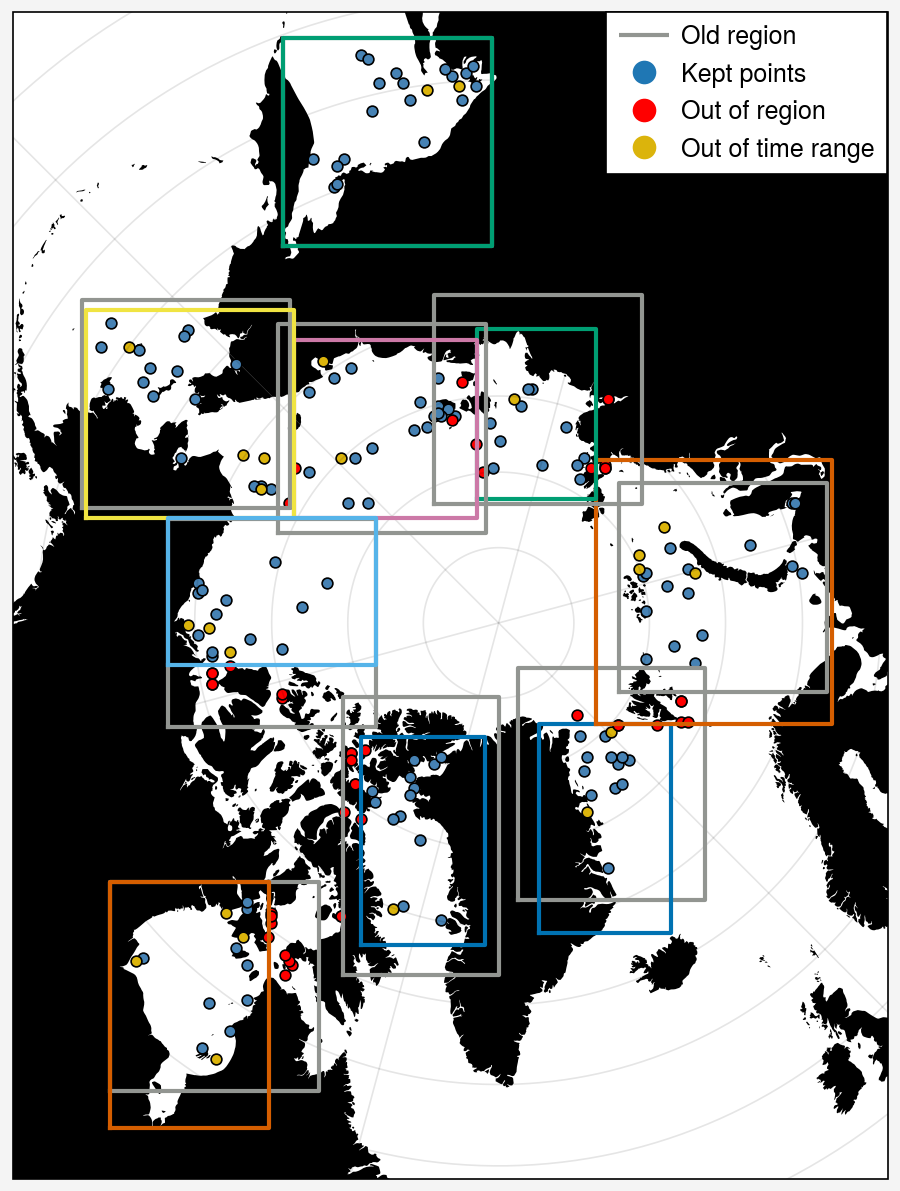

In [14]:
# Show the original sample and the changed bounds
# Blue for inside, red for outside the boundaries
pplt.rc['reso'] = 'med'
pplt.rc['cartopy.circular'] = False

crs = ccrs.CRS('epsg:3413')
fig, ax = pplt.subplots(width=4.5, proj='npstere', proj_kw={'lon_0': -45})
ax.format(land=True, color='k', boundinglat=52, landzorder=0, latmax=90)
ax.set_extent([-3.5e6, 2.8e6, -4e6, 4.4e6], crs=crs)

for region in regions.index:
    xbox = np.array([old_regions.loc[region, coord] for coord in ['left_x', 'left_x', 'right_x', 'right_x', 'left_x']])
    ybox = np.array([old_regions.loc[region, coord] for coord in ['lower_y', 'upper_y', 'upper_y', 'lower_y', 'lower_y']])
    ax.plot(xbox, ybox, transform=crs, color='gray')
    
    
    xbox = np.array([regions.loc[region, coord] for coord in ['left_x', 'left_x', 'right_x', 'right_x', 'left_x']])
    ybox = np.array([regions.loc[region, coord] for coord in ['lower_y', 'upper_y', 'upper_y', 'lower_y', 'lower_y']])
    ax.plot(xbox, ybox, transform=crs)
    

good_points = init_case_list.in_new_region & init_case_list.in_time_range

ax.scatter(init_case_list.loc[good_points, 'center_lon'],
           init_case_list.loc[good_points, 'center_lat'],
           color='steelblue', edgecolor='k', marker='o', ms=15)
ax.scatter(init_case_list.loc[~init_case_list.in_time_range, 'center_lon'],
           init_case_list.loc[~init_case_list.in_time_range, 'center_lat'], color='gold', edgecolor='k', marker='o', ms=15)
ax.scatter(init_case_list.loc[~init_case_list.in_new_region, 'center_lon'],
           init_case_list.loc[~init_case_list.in_new_region, 'center_lat'], color='red', edgecolor='k', marker='o', ms=15)

h = [ax.plot([],[],ls=ls, c=c, ms=ms, m=m) for ls, c, ms, m in zip(['-', '', '', ''], ['gray', 'tab:blue', 'r', 'gold'], [0, 15, 15, 15], ['', '.', '.', '.'])
    ]
ax.legend(h, ['Old region', 'Kept points', 'Out of region', 'Out of time range'], loc='ur', ncols=1, alpha=1)

## Drawing new samples
This section draws new samples to match the improved boundaries.

Along with the change in boundaries to better match standard marginal sea definitions and avoid overlaps, we focus on the time range where MASIE sea ice extent data is available. Thus we need to see how many new samples to draw to replace the discarded samples. 

In [15]:
# Number of samples that should come from each month
init_case_list['month'] = init_case_list.start_date.dt.month
init_counts = (init_case_list.groupby(['region', 'month']).count()).pivot_table(index='region', columns='month', values='center_x').fillna(0).astype(int)
init_counts

filter_counts = (init_case_list.loc[init_case_list.in_new_region & init_case_list.in_time_range].groupby(['region', 'month']).count()).pivot_table(index='region', columns='month', values='center_x').fillna(0).astype(int)
filter_counts

month,3,4,5,6,7,8,9
region,,,,,,,
baffin_bay,3,3,2,2,1,1,1
barents_kara_seas,3,3,2,3,2,3,1
beaufort_sea,2,1,1,1,3,2,3
bering_chukchi_seas,2,3,4,3,3,1,0
east_siberian_sea,3,3,3,3,1,2,3
greenland_sea,0,2,2,2,3,2,1
hudson_bay,0,1,3,2,2,1,0
laptev_sea,2,3,1,1,1,2,1
sea_of_okhostk,6,5,4,4,0,0,0


### Simple cases
Baffin Bay, Beaufort Sea, East Siberian Sea, Sea of Okhostk, and Laptev Sea all are only reduced in size: thus, we keep all samples from the original that are still in the time range, and draw new samples to bring the numbers back to the init counts.

Where we've only discarded samples from restricting the area and date range, we add new samples to bring the numbers to the expected count. We draw the maximum number of samples needed by month, then take the samples in the order they were drawn.

In [498]:
# Case numbers from init list to keep
keep_init = []

# Newly generated samples
new_samples = []
for region in ['baffin_bay', 'beaufort_sea', 'east_siberian_sea', 'sea_of_okhostk', 'laptev_sea']:
    num_new = init_counts.loc[region,:] - filter_counts.loc[region,:]
    n = 10*max(num_new)
    candidates = find_candidates(n_samples=n,
                    region_info=regions.loc[region],
                    dx=100,
                    sic_path=sic_dataloc,
                    sif_threshold=0.25,
                    margin=50, start_year=2006, end_year=2022,
                    min_samples_per_month=max(num_new))
    
    new_sample_indices = []
    for month in num_new.index:
        count = 0
        cases = candidates.loc[candidates.month == month].index.values
        while count < num_new[month]:
            if len(cases) > count:
                new_sample_indices.append(cases[count])
            count += 1
    
    new_samples.append(candidates.loc[new_sample_indices].copy())

    # Keep the filtered original sample
    for cn in init_case_list.loc[(init_case_list.region == region) & (init_case_list.in_new_region & init_case_list.in_time_range)].index:
        keep_init.append(cn)


# Complex cases
For cases where is a shift in the coverage area, we draw a full new sample first. Then, we keep the original samples up to the number of samples in the original region in the candidate list. Finally, we add samples from the candidate list until we have the original number of samples per month.

In [499]:
for region in ['barents_kara_seas', 'greenland_sea', 'bering_chukchi_seas', 'hudson_bay']:
    keep_old = []
    num_per_month = init_counts.loc[region,:]
    # - filter_counts.loc[region,:]
    n = 10*max(num_per_month)
    candidates = find_candidates(n_samples=n,
                    region_info=regions.loc[region],
                    dx=100,
                    sic_path=sic_dataloc,
                    sif_threshold=0.25,
                    margin=50, start_year=2006, end_year=2022,
                    min_samples_per_month=max(num_per_month))
    
    # Identify how many to keep from the original sample 
    candidates['in_old_region'] = False
    for name, row in candidates.iterrows():
        candidates.loc[name, 'in_old_region'] = in_box(row.center_x, row.center_y, old_regions.loc[row.region, 'left_x'],
                                                       old_regions.loc[row.region, 'right_x'], old_regions.loc[row.region, 'lower_y'],
                                                       old_regions.loc[row.region, 'upper_y'])
    
    # "in_new_region" refers to samples that are outside the old region
    candidates['in_new_region'] = ~candidates['in_old_region']    

    # Get the number of candidates needed per month
    candidates['keep_idx'] = False
    months = []
    for month, group in candidates.groupby('month'):
        months.append(month)
        candidates.loc[group.index.values[0:num_per_month[month]], 'keep_idx'] = True
    candidates = candidates.loc[candidates['keep_idx'], :].copy()
    candidates.drop('keep_idx', axis=1, inplace=True)
    
    # Count number of samples in old area
    num_old_to_keep = candidates.loc[candidates.in_old_region].groupby('month').count()['region']
    num_new_to_keep = candidates.loc[~candidates.in_old_region].groupby('month').count()['region']

    # Make sure all months are in the index, even if no data in month
    num_old_to_keep = num_old_to_keep.reindex_like(pd.Series(np.nan, index=months)).fillna(0).astype(int)
    num_new_to_keep = num_new_to_keep.reindex_like(pd.Series(np.nan, index=months)).fillna(0).astype(int)
    
    keep_new = []
    for month in months:
        old_cases = init_case_list.loc[(init_case_list.in_new_region & init_case_list.in_time_range) & (init_case_list.month == month)]
        old_cases = old_cases.loc[old_cases.region == region].index
        # If we need more samples in the old region than we have left,
        # keep all the original samples
        if num_old_to_keep[month] >= filter_counts.loc[region, month]:
            if filter_counts.loc[region, month] > 0:
                for cn in old_cases:
                    keep_old.append(cn)
        # if we have too many samples from the old region, keep the number we need
        elif num_old_to_keep[month] < filter_counts.loc[region, month]:
            for cn in old_cases[0:num_old_to_keep[month]]:
                keep_old.append(cn)
        # Add new samples from the old region to bring the number up to the right amount
        if num_old_to_keep[month] - filter_counts.loc[region, month] > 0:
            n_new = num_old_to_keep[month] - filter_counts.loc[region, month]
            for idx in candidates.loc[candidates.in_old_region & (candidates.month == month)].index[0:n_new]:
                keep_new.append(idx)

        # Finally, add samples from the new region
        # The total from the new and old samples across all months should be the same as the sum of the init counts!
        # Doesn't add up for B-K seas -- recheck logic!
        if month in num_new_to_keep:
            n_new = num_new_to_keep[month]
            if n_new > 0:
                for idx in candidates.loc[~candidates.in_old_region & (candidates.month == month)].index[0:n_new]:
                    keep_new.append(idx)

    results = pd.DataFrame({'OldRegion': num_old_to_keep, 'NewRegion': num_new_to_keep,
              'KeptOld': init_case_list.loc[keep_old].groupby('month').count()['region'],
              'KeptNew': candidates.loc[keep_new].groupby('month').count()['region']}).fillna(0).astype(int)
    results['InitSampleSize'] = init_counts.loc[region]
    results['FinalSampleSize'] = results['KeptOld'] + results['KeptNew']
    if ~np.all(results['InitSampleSize'] == results['FinalSampleSize']):
        print(region, 'sample incomplete')
        
    new_samples.append(candidates.loc[keep_new,:].copy())
    keep_init += keep_old

In [500]:
# Merge into a dataframe
columns = ['region', 'start_date', 'center_lon', 'center_lat', 'center_x',
       'center_y', 'month', 'sea_ice_fraction', 'mean_sea_ice_concentration', 'init_case_number']

new_samples = pd.concat(new_samples)
new_samples['init_case_number'] = -1
init_case_list['init_case_number'] = init_case_list.index
new_case_list = pd.concat([init_case_list.loc[keep_init, columns], new_samples.loc[:, columns]], axis=0)
new_case_list = new_case_list.sort_values(['region', 'center_lon']).reset_index(drop=True)
new_case_list['case_number'] = [str(int(x + 1)).zfill(3) for x in new_case_list.index]
new_case_list['start_date'] = [pd.to_datetime(x) for x in new_case_list['start_date']]

In [501]:
column_order = ['case_number', 'region', 'start_date', 'center_lon', 'center_lat', 'center_x',
       'center_y', 'month', 'sea_ice_fraction', 'mean_sea_ice_concentration',
       'init_case_number']
new_case_list.loc[:, column_order].to_csv('../data/metadata/validation_dataset_case_list.csv')

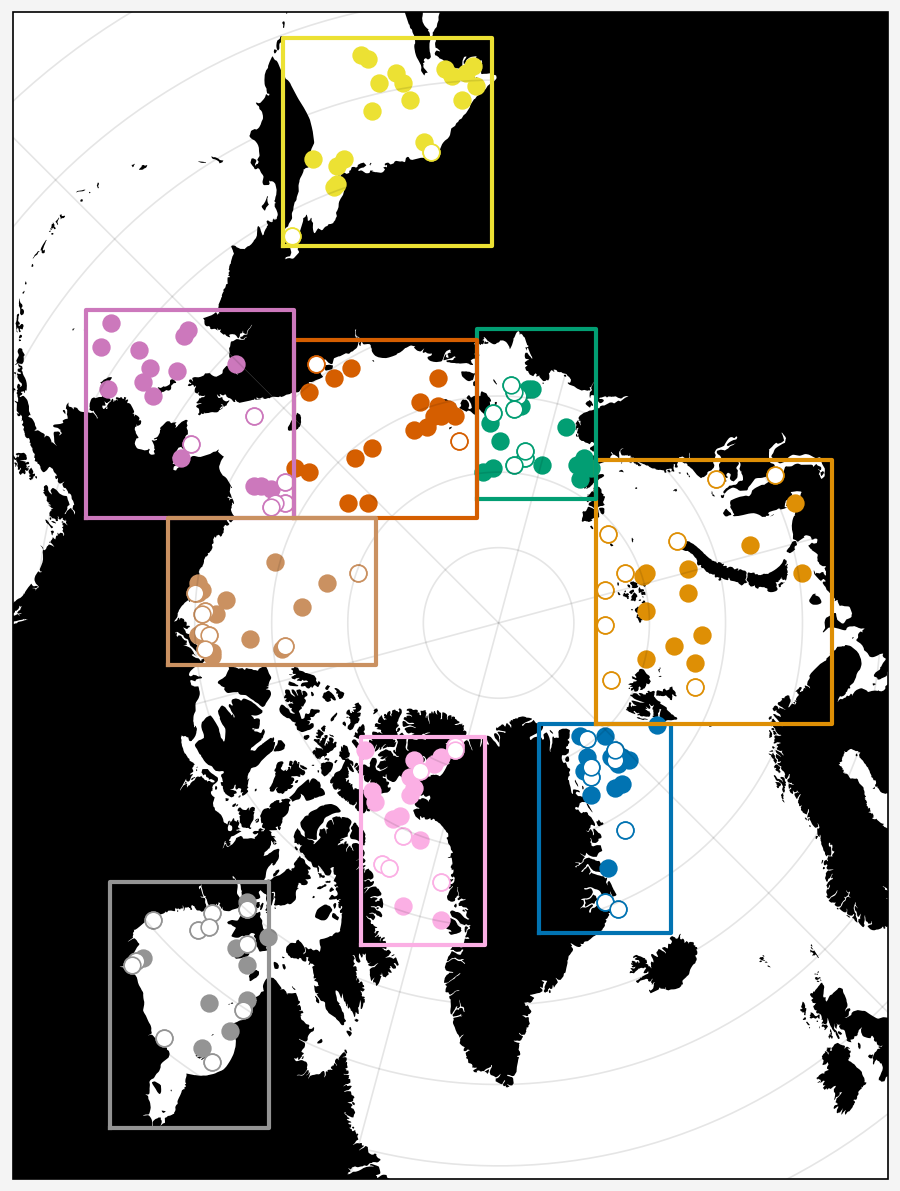

In [503]:
# Plot new samples as white dots, retained old samples as solid colors
pplt.rc['reso'] = 'med'
pplt.rc['cartopy.circular'] = False
colors = {region: c['color'] for region, c in zip(
            regions.index,
            pplt.Cycle('colorblind10', len(regions)))}


crs = ccrs.CRS('epsg:3413')
fig, ax = pplt.subplots(width=4.5, proj='npstere', proj_kw={'lon_0': -45})
ax.format(land=True, color='k', boundinglat=52, landzorder=0, latmax=90)
ax.set_extent([-3.5e6, 2.8e6, -4e6, 4.4e6], crs=crs)

for region in regions.index:
  
    xbox = np.array([regions.loc[region, coord] for coord in ['left_x', 'left_x', 'right_x', 'right_x', 'left_x']])
    ybox = np.array([regions.loc[region, coord] for coord in ['lower_y', 'upper_y', 'upper_y', 'lower_y', 'lower_y']])
    ax.plot(xbox, ybox, transform=crs, color=colors[region])
    ax.scatter(new_case_list.loc[new_case_list.region == region, 'center_lon'],
                new_case_list.loc[new_case_list.region == region, 'center_lat'], color=colors[region])
    ax.scatter(new_case_list.loc[(new_case_list.region == region) & (new_case_list.init_case_number < 0), 'center_lon'],
                new_case_list.loc[(new_case_list.region == region) & (new_case_list.init_case_number < 0), 'center_lat'], edgecolor=colors[region], facecolor='w')

# Converting to a file to run on Oscar
For the IFT-Pipeline, we need a CSV with case names and the coordinates for the bounding boxes. We'll reformat and save this there.

In [518]:
import pandas as pd
df = pd.read_csv('../data/metadata/validation_dataset_case_list.csv', index_col=0, parse_dates=['start_date'])
# fullname,case_number,location,dx,left_x,right_x,lower_y,top_y,center_x,center_y,center_lat,center_lon,startdate,enddate

# 
df['fullname'] = ['-'.join([str(cn).zfill(3), r, '100km', sd.strftime('%Y-%m-%d')]) for cn, r, sd in zip(df.case_number, df.region, df.start_date)]
dx = 50e3
df['left_x'] = df['center_x'] - dx
df['right_x'] = df['center_x'] + dx
df['lower_y'] = df['center_y'] - dx
df['top_y'] = df['center_y'] + dx
df['dx'] = '100km'
df.rename({'start_date': 'startdate', 'region': 'location'}, axis=1, inplace=True)
df['enddate'] = [sd + pd.to_timedelta(1, unit='d') for sd in df['startdate']]
df['case_number'] = [str(x).zfill(3) for x in df['case_number']]

In [521]:
df[['fullname','case_number','location','dx','left_x','right_x',
    'lower_y','top_y','center_x','center_y','center_lat','center_lon',
    'startdate','enddate']].to_csv('../data/metadata/iftp_case_list.csv')

# Drawing new samples based on the MASIE results

I first checked whether any of the original sample were available as "back up" choices. Unfortunately, all of these were before 2006, so the MASIE data isn't available. Next step is to use the sampling routine.

 Samples to replace:
| Number | Regions | Date | 
| --- | --- | --- |
| 38 |	barents_kara_seas |	2016-08-29	|
| 40 |	barents_kara_seas |	2011-09-25	|
| 102 |	east_siberian_sea |	2011-07-13	|
| 135 |	hudson_bay		 |	2006-07-18	|
| 175 |	sea_of_okhostk |	2006-06-29	|
| 64 | bering_chukchi_seas | 2007-07-27 |
| 83 | bering_chukchi_seas | 2011-07-15 |
| 106 | greenland_sea | 2017-09-13 |
| 134 | hudson_bay | 2010-08-12 |
| 136 | hudson_bay | 2006-08-02 |

To find the new samples, I ran the sampling routine, then examined the Worldview imagery for that date to make sure the summer SIC bias wasn't affecting the choice.


In [16]:
# The merged list has the updated values from resampling.
updated_list = pd.read_csv('../data/metadata/merged_validation_table.csv', index_col='case_number')

In [17]:
# Round one: 38, 40, 102, 135, 175
# updated_list.loc[[38, 40, 102, 135, 175],['region', 'start_date', 'center_lon', 'center_lat']]

# Round two: 64, 83, 106, 134, 136
updated_list.loc[[64, 83, 106, 134, 136],['region', 'start_date', 'center_lon', 'center_lat']]

,region,start_date,center_lon,center_lat
case_number,,,,
64,bering_chukchi_seas,2007-07-27,-179.618034,65.870007
64,bering_chukchi_seas,2007-07-27,-179.618034,65.870007
83,bering_chukchi_seas,2011-07-15,-162.434985,66.528209
83,bering_chukchi_seas,2011-07-15,-162.434985,66.528209
106,greenland_sea,2017-09-13,-24.249204,70.321239
106,greenland_sea,2017-09-13,-24.249204,70.321239
134,hudson_bay,2010-08-12,-87.006868,65.369332
134,hudson_bay,2010-08-12,-87.006868,65.369332
136,hudson_bay,2006-08-02,-86.308614,65.039779


In [18]:
init_case_list['new_case_number'] = np.nan
for row, data in updated_list.iterrows():
    if data.init_case_number > 0:
        init_case_list.loc[data.init_case_number, 'new_case_number'] = row

In [21]:
# Checking if any of the original sample can be used.
# In both cases, my finding was no, none of the original sample was appropriate (no ice)
init_case_list.loc[(init_case_list.new_case_number.isnull() & (init_case_list.month == 7)) &\
                    (init_case_list.start_date.dt.year >= 2006)]

,region,start_date,center_lon,center_lat,center_x,center_y,month,sea_ice_fraction,mean_sea_ice_concentration,start_doy,in_new_region,in_time_range,new_case_number
case_number,,,,,,,,,,,,,
441,baffin_bay,2020-07-26,-92.095253,76.667722,-1062500.0,-987500.0,7,1.000,0.789,208,False,True,NaN
453,hudson_bay,2006-07-18,-86.308614,65.039779,-1812500.0,-2062500.0,7,0.727,0.504,199,True,True,NaN
353,laptev_sea,2007-07-12,142.193470,78.062064,-162500.0,1287500.0,7,1.000,0.727,193,False,True,NaN
386,laptev_sea,2018-07-20,143.591225,73.881487,-262500.0,1737500.0,7,1.000,0.600,201,False,True,NaN


Process: we use the find candidates function to identify a list of cases, then look at each individually. Starting from the first, we check the days around the sampled day in the Worldview imagery. If it's a region within the sea ice region, then we keep it.

In [29]:
region = 'hudson_bay'
n = 50
candidates = find_candidates(n_samples=n,
                region_info=regions.loc[region],
                dx=100,
                sic_path=sic_dataloc,
                sif_threshold=0.25,
                margin=50, start_year=2006, end_year=2022,
                min_samples_per_month=n)

In [67]:
candidates.loc[[1],:]

,region,start_date,center_lon,center_lat,center_x,center_y,sea_ice_fraction,mean_sea_ice_concentration,month
1,east_siberian_sea,2022-07-02,155.013567,71.609279,-687500.0,1887500.0,1.0,0.855,7


In [70]:
candidates.loc[[9],:]

,region,start_date,center_lon,center_lat,center_x,center_y,sea_ice_fraction,mean_sea_ice_concentration,month
9,hudson_bay,2017-07-06,-91.780642,59.221811,-2487500.0,-2337500.0,0.64,0.43,7


In [73]:
# 9 - no ice
candidates.loc[[17],:]

,region,start_date,center_lon,center_lat,center_x,center_y,sea_ice_fraction,mean_sea_ice_concentration,month
17,sea_of_okhostk,2010-06-04,139.6859,55.708056,-312500.0,3812500.0,0.8,0.536,6


In [64]:
# Barents Kara Seas in September will likely only have ice
# north of approx 80 latitude
new_samples = [5, 0]
sample_numbers = [38, 40]
candidates.loc[new_samples]

,region,start_date,center_lon,center_lat,center_x,center_y,sea_ice_fraction,mean_sea_ice_concentration,month
5,barents_kara_seas,2014-08-02,88.339718,78.769967,887500.0,837500.0,1.0,0.752,8
0,barents_kara_seas,2007-09-12,12.757532,81.149074,812500.0,-512500.0,0.6,0.696,9


In [24]:
new_samples = [0, 6]
candidates.loc[new_samples]

,region,start_date,center_lon,center_lat,center_x,center_y,sea_ice_fraction,mean_sea_ice_concentration,month
0,bering_chukchi_seas,2015-07-16,-167.047235,73.368234,-1537500.0,962500.0,0.56,0.455,7
6,bering_chukchi_seas,2018-07-26,-161.737110,72.937768,-1662500.0,837500.0,0.96,0.497,7


In [28]:
candidates.loc[[1]]

,region,start_date,center_lon,center_lat,center_x,center_y,sea_ice_fraction,mean_sea_ice_concentration,month
1,greenland_sea,2014-09-11,-13.431029,78.793415,637500.0,-1037500.0,0.92,0.715,9


In [33]:
# Checked and rejected:
# 5, 12, 17, 19, 32, 35
# 41, 42, 44, 50, 54, 74
# 78, 93, 
new_samples = [85, 97]
candidates.loc[new_samples,]

,region,start_date,center_lon,center_lat,center_x,center_y,sea_ice_fraction,mean_sea_ice_concentration,month
85,hudson_bay,2015-08-10,-85.749345,66.119475,-1712500.0,-1987500.0,1.0,0.732,8
97,hudson_bay,2012-08-14,-84.364059,65.442785,-1712500.0,-2087500.0,1.0,0.806,8


New samples:
|case_number | region 	| start_date 	| center_lon 	| center_lat 	| center_x 	| center_y 	| sea_ice_fraction 	| mean_sea_ice_concentration 	| month |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | -- |
| 38 |	barents_kara_seas |	2014-08-02 | 88.339718 | 78.769967 	| 887500.0 	| 837500.0 |	1.0 	| 0.752 | 8 |
| 40 |	barents_kara_seas |	2007-09-12 | 12.757532 	| 81.149074 | 812500.0 	| -512500.0 | 0.6 | 0.696 | 9 |
| 102 |	east_siberian_sea |	2022-07-02 | 155.013567 | 71.609279 | -687500.0 | 1887500.0 | 1.0 | 0.855 | 7 |
| 135 |	hudson_bay 	| 2017-07-06	| -91.780642	| 59.221811	| -2487500.0	| -2337500.0	| 0.64	| 0.43	| 7 |
| 175 |	sea_of_okhostk | 2010-06-04 | 139.6859 | 55.708056 | -312500.0 | 3812500.0 | 0.8 | 0.536 | 6 |
| 64 | bering_chukchi_seas | 2015-07-16 | -167.047235 | 73.368234 | -1537500.0 | 962500.0 | 0.56 | 0.455 | 7| 
| 83 | bering_chukchi_seas | 2018-07-26 | -161.737110 | 72.937768 | -1662500.0 | 837500.0 | 0.96 | 0.497 | 7| 
| 106 | greenland_sea | 2014-09-11 | -13.431029 | 78.793415 | 637500.0 | -1037500.0 | 0.92 | 0.715 | 9 | 
| 134 | hudson_bay | 2015-08-10 | -85.749345 | 66.119475 | -1712500.0 | -1987500.0 | 1.0 | 0.732 | 8 | 
| 136 | hudson_bay | 2012-08-14 | -84.364059 | 65.442785 | -1712500.0 | -2087500.0 | 1.0 | 0.806 | 8 | 


In [38]:
# Merging to make the IFTP case list
case_list = pd.read_csv('../data/metadata/iftp_case_list.csv', index_col=0)

new_samples = pd.DataFrame(data=[ 
    [38,'barents_kara_seas','2014-08-02',88.339718,78.769967,887500.0,837500.0,1.0,0.752],
    [40,'barents_kara_seas','2007-09-12',12.757532,81.149074,812500.0,-512500.0,0.6,0.696],
    [102,'east_siberian_sea','2022-07-02',155.013567,71.609279,-687500.0,1887500.0,1.0,0.855],
    [135,'hudson_bay','2017-07-06',-91.780642,59.221811,-2487500.0,-2337500.0,0.64,0.43],
    [175,'sea_of_okhostk','2010-06-04',139.6859,55.708056,-312500.0,3812500.0,0.8,0.536],
    [64,'bering_chukchi_seas','2015-07-16',-167.047235,73.368234,-1537500.0,962500.0,0.56,0.455],
    [83,'bering_chukchi_seas','2018-07-26',-161.737110,72.937768,-1662500.0,837500.0,0.96,0.497],
    [106,'greenland_sea','2014-09-11',-13.431029,78.793415,637500.0,-1037500.0,0.92,0.715],
    [134,'hudson_bay','2015-08-10',-85.749345,66.119475,-1712500.0,-1987500.0,1.0,0.732],
    [136,'hudson_bay','2012-08-14',-84.364059,65.442785,-1712500.0,-2087500.0,1.0,0.806]],
                        columns=['case_number', 	'location', 	'startdate', 	'center_lon',
                                 'center_lat', 	'center_x',  'center_y', 	'sea_ice_fraction',
                                 'mean_sea_ice_concentration'])
new_samples['enddate'] = [(pd.to_datetime(sd) + pd.to_timedelta('1d')).strftime('%Y-%m-%d') for sd in new_samples['startdate']]
new_samples['left_x'] = new_samples['center_x'] - 50e3 
new_samples['right_x'] = new_samples['center_x'] + 50e3 
new_samples['lower_y'] = new_samples['center_y'] - 50e3
new_samples['top_y'] = new_samples['center_y'] + 50e3
new_samples['dx'] = '100km'
column_order = ['fullname', 'case_number', 'location', 'dx', 'left_x', 'right_x',
       'lower_y', 'top_y', 'center_x', 'center_y', 'center_lat', 'center_lon',
       'startdate', 'enddate']
new_samples['fullname'] = ['-'.join([str(cn).zfill(3), rg, '100km', sd]) for cn, rg, sd in zip(new_samples.case_number,
                                                                                             new_samples.location,
                                                                                             new_samples.startdate)]
keep_idx = [x for x in case_list.index if case_list.loc[x, 'case_number'] not in new_samples['case_number'].values]
pd.concat([case_list.loc[keep_idx], new_samples]).sort_values('case_number').to_csv('../data/metadata/iftp_case_list_updated.csv', index=False)

In [64]:
# Update the validation case list file
case_list = pd.read_csv('../data/metadata/validation_dataset_case_list.csv', index_col=0)
case_list = case_list.set_index('case_number', drop=True)

# update list:
for cn in new_samples.case_number:
    for col in case_list:
        if col in new_samples.columns:
            case_list.loc[cn, col] = new_samples.loc[new_samples.case_number == cn, col].squeeze()
    case_list.loc[cn, 'month'] = pd.to_datetime(case_list.loc[cn, 'start_date']).month
    case_list.loc[cn, 'init_case_number'] = -1
    case_list.loc[cn,'start_date'] = new_samples.loc[new_samples.case_number == cn, 'startdate'].squeeze()

In [65]:
case_list.loc[new_samples['case_number']]

,region,start_date,center_lon,center_lat,center_x,center_y,month,sea_ice_fraction,mean_sea_ice_concentration,init_case_number
case_number,,,,,,,,,,
38,barents_kara_seas,2014-08-02,88.339718,78.769967,887500.0,837500.0,8,1.00,0.752,-1
40,barents_kara_seas,2007-09-12,12.757532,81.149074,812500.0,-512500.0,9,0.60,0.696,-1
102,east_siberian_sea,2022-07-02,155.013567,71.609279,-687500.0,1887500.0,7,1.00,0.855,-1
135,hudson_bay,2017-07-06,-91.780642,59.221811,-2487500.0,-2337500.0,7,0.64,0.430,-1
175,sea_of_okhostk,2010-06-04,139.685900,55.708056,-312500.0,3812500.0,6,0.80,0.536,-1
64,bering_chukchi_seas,2015-07-16,-167.047235,73.368234,-1537500.0,962500.0,7,0.56,0.455,-1
83,bering_chukchi_seas,2018-07-26,-161.737110,72.937768,-1662500.0,837500.0,7,0.96,0.497,-1
106,greenland_sea,2014-09-11,-13.431029,78.793415,637500.0,-1037500.0,9,0.92,0.715,-1
134,hudson_bay,2015-08-10,-85.749345,66.119475,-1712500.0,-1987500.0,8,1.00,0.732,-1


In [67]:
! mv ../data/metadata/validation_dataset_case_list.csv ../data/metadata/init_validation_dataset_case_list.csv
case_list.sort_index().to_csv('../data/metadata/validation_dataset_case_list.csv')

# Dataset statistics

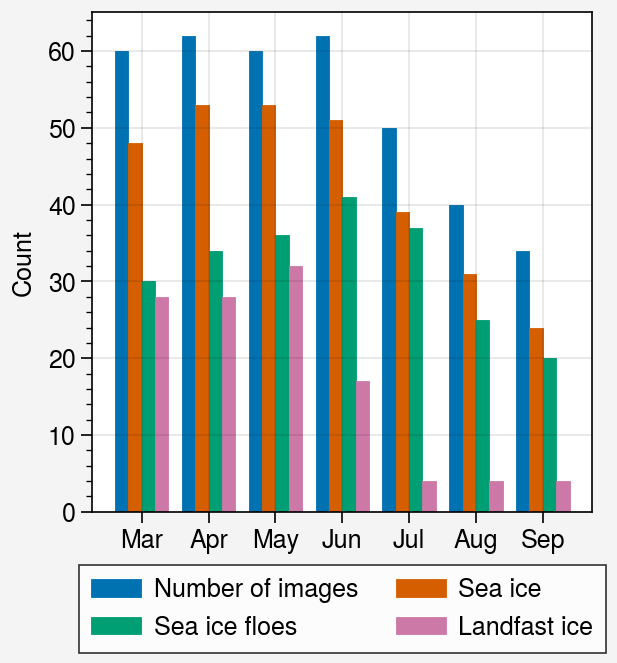

In [68]:
import proplot as pplt
import pandas as pd
import numpy as np

fig, ax = pplt.subplots()

df = pd.read_csv('../data/metadata/merged_validation_table.csv', parse_dates=['start_date'])
df['month'] = df['start_date'].dt.month
df.loc[:, 'visible_sea_ice'] = df.loc[:, 'visible_sea_ice'].where(df.loc[:, 'visible_sea_ice']=='yes')
df.loc[:, 'visible_landfast_ice'] = df.loc[:, 'visible_landfast_ice'].where(df.loc[:, 'visible_landfast_ice']=='yes')
df.loc[:, 'visible_floes'] = df.loc[:, 'visible_floes'].where(df.loc[:, 'visible_floes']=='yes')
df.rename({'cloud_fraction_manual': 'Number of images',
                  'visible_sea_ice': 'Sea ice',
                  'visible_floes': 'Sea ice floes',
                  'visible_landfast_ice': 'Landfast ice'}, axis=1, inplace=True)

ax.bar(df.loc[:, ['month', 'Number of images', 'Sea ice', 'Sea ice floes', 'Landfast ice']].groupby('month').count())
ax.legend(loc='b', ncols=2)
ax.format(ylabel='Count', xlabel='', xlocator=np.arange(3, 10),
          xformatter=['Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'],
          xtickminor=False)
fig.save('../figures/random_sample_summary_chart.png', dpi=300)

# Analysis progress

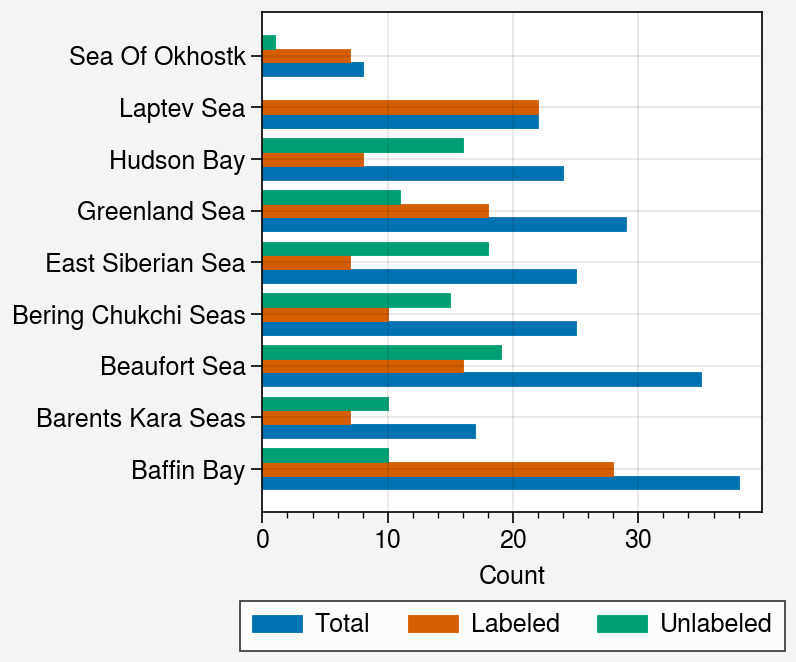

In [69]:
df = pd.read_csv('../data/metadata/merged_validation_table.csv', parse_dates=['start_date'])
df['month'] = df['start_date'].dt.month
total_to_label = df.loc[df.visible_floes == 'yes'].groupby('region').count()['case_number']
total_labeled = df.loc[(df.visible_floes == 'yes') & df.fl_analyst.notnull(),:].groupby('region').count()['case_number']
total_unlabeled = df.loc[(df.visible_floes == 'yes') & df.fl_analyst.isnull(),:].groupby('region').count()['case_number']
df2 = pd.DataFrame({'Total': total_to_label, 'Labeled': total_labeled, 'Unlabeled': total_unlabeled})
df2.index = [x.replace('_', ' ').title() for x in df2.index]

fig, ax = pplt.subplots()
ax.barh(df2)
ax.format(xlabel='Count')
ax.legend(loc='b')